# TF symbolic engine 

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib.utils import make_graph
from IPython.display import Image
tf.__version__

2023-10-18 18:21:48.852776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.14.0'

## TF is a symbolic computing + optimization library for machine learning problems

ML expressions involve:

- variables representing data as n-dimensional objects
- variables representing parameters as n-dimensional objects
- mostly matrix operations (multiplications, convolutions, etc.)
- some non linear operations (activation functions)


**Recall** that in `sympy` we **FIRST** define expressions (a computational graph) and **THEN** we evaluate them feed concrete values.

Tensorflow **INTEGRATES** both aspects so that building computational graphs **LOOKS LIKE** writing regular Python code as must as possible.

- a `tf.Variable` represents a **symbolic** variable, that **contains a value**


See:

- https://www.tensorflow.org/guide/keras/train_and_evaluate
- https://www.tensorflow.org/guide/keras/custom_layers_and_models
- https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

In [2]:
x = tf.Variable(initial_value=[7], name="x", dtype=tf.float32)
y = tf.Variable(initial_value=[9], name="y", dtype=tf.float32)
f = x**2+y**3
f

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([778.], dtype=float32)>

`f` is **SYMBOLIC EXPRESSION** (a `Tensor` in TF terms) that also contains a value attached to it.


for which TF can obtain gradients automatically. This might seem a rather akward way of obtaining the gradient (with `GradientTape`). The goal is that you **write code as in Python** and TF takes care of building the computational graph with it. 


In [3]:
with tf.GradientTape(persistent=True) as t:
    f = x**2 + y**3
    
print (t.gradient(f, x), t.gradient(f, y))
    

tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


In [4]:
print (t.gradient(f, [x,y]))


[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([14.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([243.], dtype=float32)>]


usually expressions are built within functions decorated with `@tf.function` for performance

In [5]:
@tf.function
def myf(x,y):
    return x**2 + y**3

In [6]:
with tf.GradientTape(persistent=True) as t:
    f = myf(x,y)
    
print (t.gradient(f, x), t.gradient(f, y))


tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


In [7]:
!rm -rf logs
make_graph(myf, x, y, logdir="logs")


In [8]:
%tensorboard --logdir logs

## Tensors

in `Tensorflow` the notion of a Tensor is just a **symbolic multidimensional array**. 

Observe how Tensorflow naturally deals with multidimensional symbolic variables (Tensors)

$$\frac{1}{n} \sum_{i=1}^n ({\bf{w}}^T{\bf{x}}_i - y_i)^2$$

In [9]:
n = 3
X = tf.Variable(initial_value=[[2, 6], [3, 1], [4, 5]], name="X", dtype=tf.float32)
w = tf.Variable(initial_value=[[-2],[1]], name="w", dtype=tf.float32)
y = tf.Variable(initial_value=[[8],[2],[3]], name="y", dtype=tf.float32)

with tf.GradientTape(persistent=True) as t:
    f = tf.reduce_mean((tf.matmul(X,w)-y)**2)
    
g = t.gradient(f, w)
g

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-38.      ],
       [-48.666668]], dtype=float32)>

But a `tf.Tensor` is always a symbolic variable. In order to reconcile symbolic and execution worlds, `Tensorflow` **attaches** a value to each symbolic variable, and carries it forward when making derivations.

- `X`, `y` and `w` are Tensors that we define with a specific value
- `g` is a Tensor derived from `X`, `y` and `w` that have ALSO been evaluated with the corresponding values.

In [10]:
g.numpy()

array([[-38.      ],
       [-48.666668]], dtype=float32)

## Implementing linear regresion in TF


(150, 1) (150,)


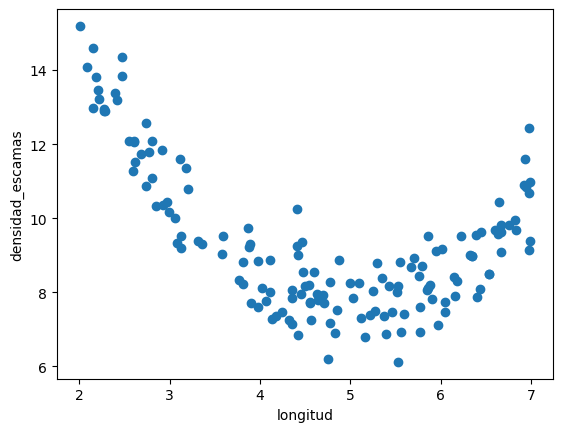

In [11]:
d = pd.read_csv("local/datasets/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)

print(X.shape, y.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
lr.coef_, lr.intercept_

(array([-0.71805906], dtype=float32), 12.689999)

 ## Version 1: raw low level with gradient descent
 
- beware of typing. `tensorflow` is very sensitive to numeric data types (`tf.float32`, `tf.float64`, etc.) Default types in `numpy` and `tensorflow` might not always be the same

In [23]:
from tqdm import tqdm
epochs = 4000
learning_rate = 0.01

# symbolic variables
w = tf.Variable(np.random.normal(size=(X.shape[-1], 1), scale=.6), dtype=tf.float32)
b = tf.Variable(np.random.normal(size=(1,), scale=.6), dtype=tf.float32)
h = []

#optimization loop
for epoch in tqdm(range(epochs)):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y.reshape(-1,1))**2)
        
    gw, gb = t.gradient(loss, [w, b])
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.88it/s]

[12.678487] [[-0.7157973]]


(0.0, 50.0)

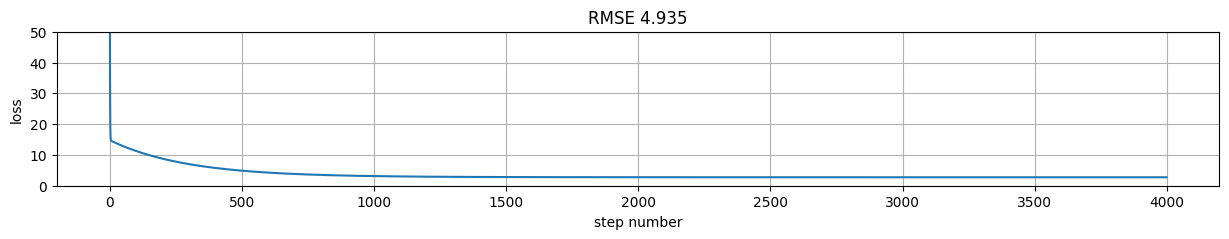

In [24]:
rmse = tf.reduce_mean((tf.matmul(X,w)+b-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 2: using `tf.function` to speed up

In [25]:
epochs = 4000

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1)).astype(np.float32)*.6) 
b.assign(np.random.normal(size=(1,)).astype(np.float32))

@tf.function
def get_gradient(w, b, X, y):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y)**2)
        
    gw, gb = t.gradient(loss, [w, b])
    return gw, gb, loss

#optimization loop
h = []
for epoch in tqdm(range(epochs)):
        
    gw, gb, loss = get_gradient(w, b, X, y.reshape(-1,1))
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)

    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]

print (b.numpy(), w.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 840.83it/s]


[12.6763935] [[-0.7153859]]


(0.0, 50.0)

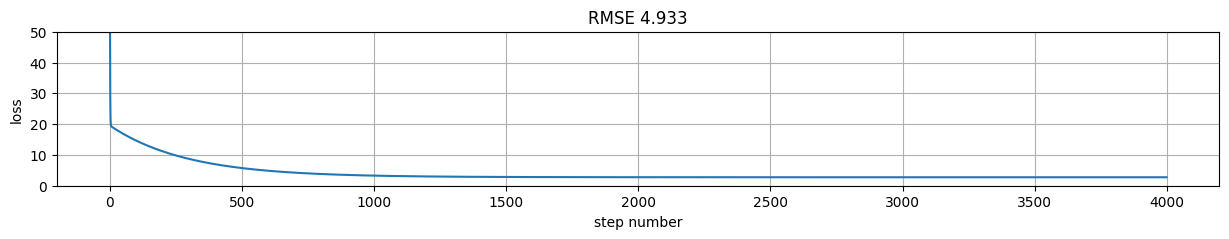

In [26]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 3: using batches with random shuffling (stochastic gradient descent)

notice we tune the number of epochs as the number of weights updates increases

In [77]:
#optimization loop
batch_size = 16
epochs = 400

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1))*.6) 
b.assign(np.random.normal(size=(1,)))

h = []

for epoch in tqdm(range(epochs)):
    
    idxs = np.random.permutation(len(X))
    
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
        
        gw, gb, loss = get_gradient(w, b, X_batch, y_batch.reshape(-1,1))

        w.assign_sub(learning_rate * gw)
        b.assign_sub(learning_rate * gb)
        
        h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 85.38it/s]

[12.667722] [[-0.71434104]]


(0.0, 50.0)

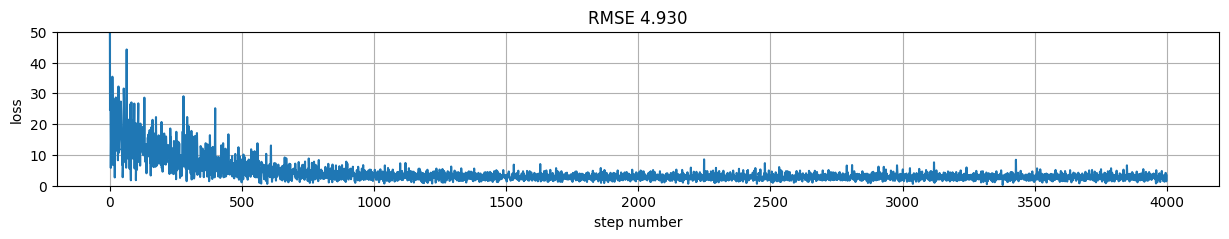

In [78]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 4: packing up with Keras `class` API  and custom SGD

observe:

- the`build` method that is called by Keras whenever `input_shape` is known
- we use `add_weight` so that our model weights are known to the Keras model framework (`trainable_variables`, `get_weights`, etc.) 

see [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [79]:
class LinearRegressionModel4(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
        self.b = self.add_weight(shape=(1,), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = tf.reduce_mean( (self(X)-y)**2)

        gw, gb = t.gradient(loss, [self.w, self.b])
        return gw, gb, loss

    def fit(self, X,y, epochs, batch_size=16, learning_rate=0.01):
        y = y.reshape(-1,1)
        self.h=[]
        for epoch in tqdm(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]            

                gw, gb, loss = self.get_gradient(X_batch,y_batch)
                self.w.assign_sub(learning_rate * gw)
                self.b.assign_sub(learning_rate * gb)
                self.h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
        self.h = np.r_[self.h]


In [80]:
model = LinearRegressionModel4()

observe that we can use the object directly on data to get predictions

In [81]:
model(X[:2])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.14747247],
       [-0.119949  ]], dtype=float32)>

or with the  `.predict` method

In [82]:
model.predict(X[:2])

1/1 [==============================] - 0s 60ms/step


array([[-0.14747247],
       [-0.119949  ]], dtype=float32)

In [83]:
model.trainable_variables

[<tf.Variable 'linear_regression_model4_2/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.01655438]], dtype=float32)>,
 <tf.Variable 'linear_regression_model4_2/Variable:0' shape=(1,) dtype=float32, numpy=array([-0.08428116], dtype=float32)>]

In [84]:
model.get_weights()

[array([[-0.01655438]], dtype=float32), array([-0.08428116], dtype=float32)]

and fit the model

In [85]:
model.fit(X, y, epochs=400, batch_size=16)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 81.99it/s]


In [86]:
model.b.numpy(), model.w.numpy()

(array([12.6649475], dtype=float32), array([[-0.6100817]], dtype=float32))

(0.0, 50.0)

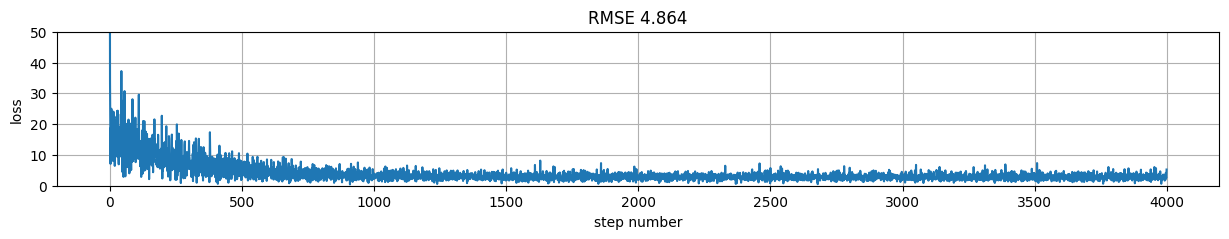

In [87]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(model.h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 5: Sequential Keras model with standard loop

In [88]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model5():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  metrics=["mean_absolute_error"],
                  loss="mse")
# equivalent forms for loss    
#                  loss = lambda y_true, y_pred: tf.reduce_mean((y_true-y_pred)**2))
#                  loss="mean_squared_error")
#                  loss=tf.keras.metrics.mean_squared_error)
    return model

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y.reshape(-1,1), test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120, 1), (30, 1), (120, 1), (30, 1))

In [90]:
!rm -rf logs
model = get_model5()

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
model.fit(X_train,y_train, epochs=100, batch_size=5, verbose=0, 
          callbacks=[tb_callback], validation_data=(X_val, y_val))

model.weights

[<tf.Variable 'dense_5/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.6312059]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([12.774989], dtype=float32)>]

history is now logged only per epoch

In [91]:
model.history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

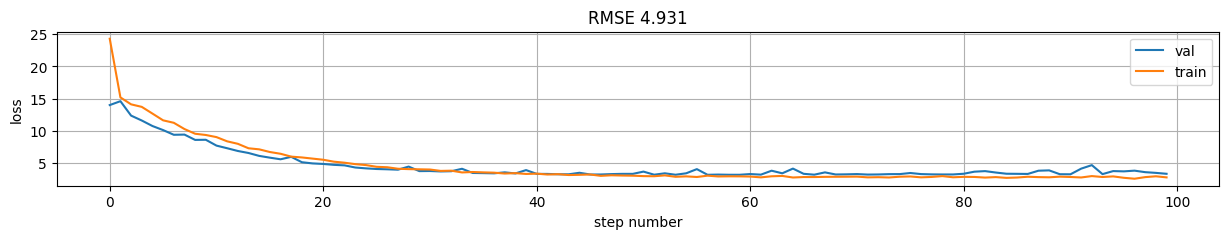

In [92]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["val_loss"], label="val"); 
plt.plot(model.history.history["loss"], label="train"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

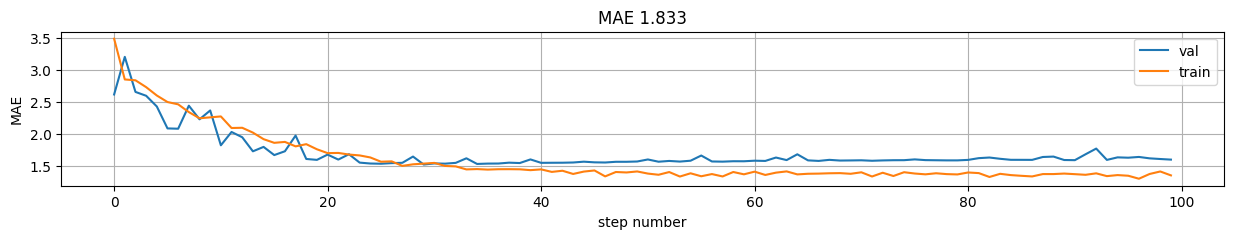

In [93]:
mae = np.mean(np.abs(predictions-y))

plt.figure(figsize=(15,2));
plt.plot(model.history.history["val_mean_absolute_error"], label="val"); 
plt.plot(model.history.history["mean_absolute_error"], label="train"); 
plt.xlabel("step number"); plt.ylabel("MAE"); plt.grid();
plt.title("MAE %.3f"%mae); plt.legend();

In [94]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 47595), started 16:14:07 ago. (Use '!kill 47595' to kill it.)

## Version 6: Custom model with Keras `class` API  and standard loop

In [95]:
class LinearRegressionModel6(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [96]:
model = LinearRegressionModel6()

In [97]:
!rm -rf logs
model = LinearRegressionModel6()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), 
           loss="mse", metrics=['mean_absolute_error'])

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)


model.fit(X_train,y_train, epochs=100, batch_size=5, callbacks=[tb_callback], 
       verbose=0, validation_data=(X_val, y_val))

You can also define your own optimizer (see this [blog](https://towardsdatascience.com/custom-optimizer-in-tensorflow-d5b41f75644a))

In [98]:
model.b.numpy(), model.w.numpy()[0]

(array([13.017648], dtype=float32), array([-0.7233677], dtype=float32))

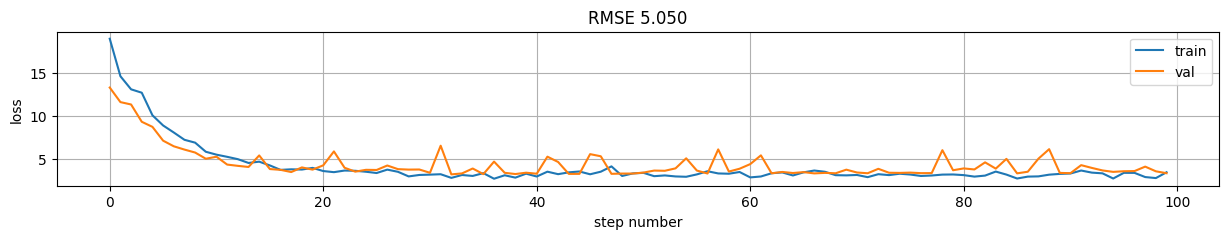

In [99]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 7: Using `train_step` $\rightarrow$ control loss and gradients on a custom model.

In [100]:
class LinearRegressionModel7(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.loss_fn = tf.keras.metrics.MeanSquaredError()
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def test_step(self, data):
        # here we implement loss by hand
        return {'loss': tf.reduce_mean((self(X)-y)**2)  }
    
    @tf.function
    def train_step(self, data):
        X,y = data
        loss_fn = lambda y_true, y_preds: tf.reduce_mean((y_true-y_preds)**2)
        with tf.GradientTape() as tape:
            # we use tf.keras loss function (equivalent to test_step)
            loss_fn = tf.keras.metrics.mean_squared_error
            loss = tf.reduce_mean(loss_fn(y, self(X)))
            
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return {'loss': loss}

In [101]:
model = LinearRegressionModel7()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02))
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.035))
model.fit(X_train,y_train, epochs=400, batch_size=5, verbose=0, validation_data=(X_val, y_val))

In [102]:
[i.numpy() for i in model.trainable_variables]

[array([[-0.67465234]], dtype=float32), array([12.980438], dtype=float32)]

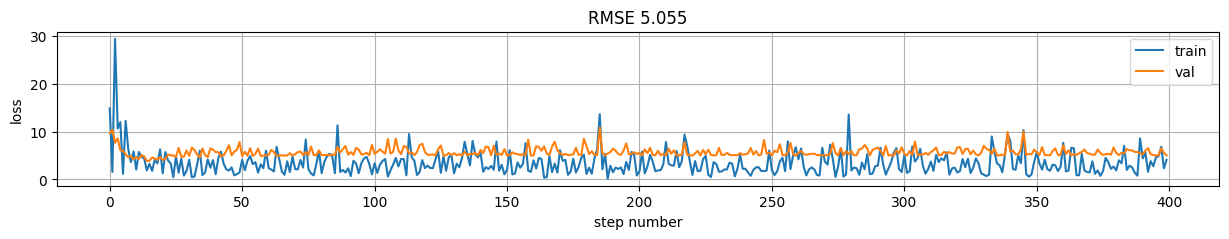

In [103]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 8: Using `train_step` $\rightarrow$ control loss and gradients on a standard model.

observe that:

- we use a standard `Dense` layer, 
- we use a custom loss function and `optimizer.apply_gradients`

In [104]:

class CustomModel(tf.keras.Model):
    
    def test_step(self, data):
        return {'loss': tf.reduce_mean((self(X)-y)**2)}    
    
    @tf.function
    def train_step(self, data):
        X,y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss_value = tf.reduce_mean((y_pred-y)**2)
            
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return {'loss': loss_value}


In [105]:
from tensorflow.keras.layers import Dense, Input
    
def get_model8():
    
    inputs = tf.keras.layers.Input(shape=(1))
    outputs = tf.keras.layers.Dense(1, activation="linear")(inputs)
    
    model = CustomModel(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02))
    return model

our custom loop (**for any model** !!!)

In [106]:
model = get_model8()
model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
model.weights

[<tf.Variable 'dense_6/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.137009]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [108]:
model.trainable_variables

[<tf.Variable 'dense_6/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.137009]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [109]:
model.fit(X_train,y_train.reshape(-1,1), epochs=400, batch_size=5, verbose=0, validation_data=(X_val, y_val))

In [110]:
model.trainable_variables

[<tf.Variable 'dense_6/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.9636562]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32, numpy=array([12.985804], dtype=float32)>]

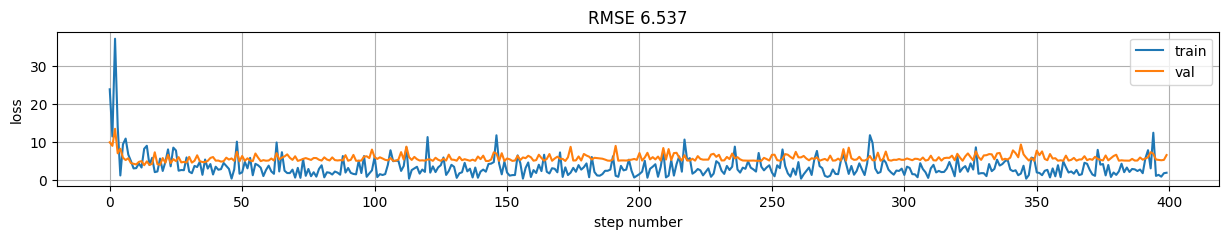

In [111]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 9: using `train_on_batch` $\rightarrow$ control data

In [112]:
epochs = 400
batch_size = 5

In [113]:
model = get_model8()
h = []
for epoch in tqdm(range(epochs)):
    idxs = np.random.permutation(len(X))
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]       
        model.train_on_batch(X_batch, y_batch)
    h.append(model.test_step([X_batch, y_batch])['loss'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.22it/s]


In [114]:
model.trainable_variables

[<tf.Variable 'dense_7/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.15614377]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(1,) dtype=float32, numpy=array([9.998391], dtype=float32)>]

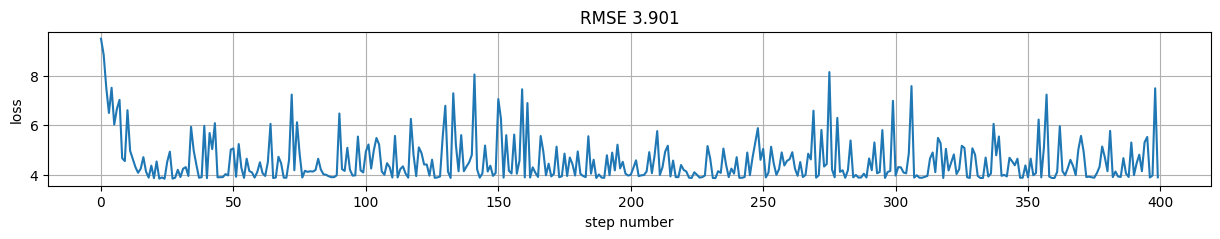

In [115]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);